# Retrieval-Augmented Generation (RAG) QA System

This notebook demonstrates the implementation and evaluation of a **Retrieval-Augmented Generation (RAG)** QA system. The project combines:
- **Document retrieval** using ChromaDB.
- **Language generation** powered by LangChain and Hugging Face models.
- **Evaluation** with metrics like BLEU, ROUGE, and BERTScore.

The dataset used is a collection of QA pairs [`dev_v2.1.json`](https://msmarco.z22.web.core.windows.net/msmarco/dev_v2.1.json.gz). The system aims to:
1. Retrieve relevant context for user questions.
2. Generate accurate and context-aware answers.
3. Evaluate performance with precision, recall, and F1 metrics.

![RAG Implementation + Evaluation Workflow](Rag_architecture.png)

**Key Tools:**
- LangChain
- ChromaDB
- Hugging Face
- BERTScore

## Testing Ollama and LangChain Integration

This section tests the integration of Ollama with LangChain to ensure that the language model responds to prompts correctly.

### Objectives:
- Test Ollama's response capabilities.
- Ensure LangChain can interact with the model using its chat interface.

In [ ]:
! pip install ollama

In [1]:
from ollama import Client
client = Client(
  host='http://localhost:11434',
  headers={'x-some-header': 'some-value'}
)

In [2]:
def get_response(prompt):
    response = client.chat(model='llama3.2:1b', messages = prompt)
    return response

In [30]:
prompt = [
    {"role": "system", "content": "You are an assitant helps to answer questions!"},
    {"role": "user", "content": "Who are you?"},
]
response = get_response(prompt)

In [31]:
print(response)

I'm an assistant here to help answer your questions and provide information on a wide range of topics. I'm a large language model, so I can provide insights and responses on many subjects, from science and history to entertainment and culture. I don't have personal experiences or emotions like humans do, but I'm designed to be helpful and provide accurate information to the best of my ability. What's on your mind?


In [ ]:
! pip install -qU langchain-ollama

In [1]:
from langchain_ollama import ChatOllama

In [2]:
llm = ChatOllama(
                model = "llama3.2",
                temperature = 0,
                num_predict = 128,
                # other params ...
            )

In [39]:
response = llm.invoke(prompt)

In [40]:
print(response.content)

I'm an assistant here to help with any questions or information you might need. My name is not publicly known, as I'm a large language model, I don't have a personal identity or personal details like humans do. I exist solely to provide information and assist with tasks to the best of my abilities, based on my training and the data I was provided with. What would you like to know or discuss?


In [5]:
from langchain.prompts import PromptTemplate

prompt_template = PromptTemplate(
    input_variables=["query"],
    template="""
    You are an assitant helps to answer questions.

    Question:
    {query}

    Answer:
    """
)

In [75]:
# chain
chain = prompt_template | llm

In [78]:
chain.invoke({"query": "who are you ?"})

AIMessage(content="I'm an artificial intelligence assistant, which means I'm a computer program designed to assist and communicate with humans. I'm here to provide information, answer questions, and help with tasks to the best of my abilities. I don't have a personal identity or consciousness like a human, but I'm constantly learning and improving to become more helpful and accurate in our conversations.", additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-01-11T19:11:54.2701998Z', 'done': True, 'done_reason': 'stop', 'total_duration': 13303344200, 'load_duration': 7747887700, 'prompt_eval_count': 46, 'prompt_eval_duration': 828000000, 'eval_count': 74, 'eval_duration': 4726000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-787e9349-dd97-422d-b56f-f3c4fded4107-0', usage_metadata={'input_tokens': 46, 'output_tokens': 74, 'total_tokens': 120})

## Data Loading and Preprocessing

### Dataset Description:

The dataset [`dev_v2.1.json`](https://msmarco.z22.web.core.windows.net/msmarco/dev_v2.1.json.gz) contains QA pairs and related passages. In this section, we:
1. Load the dataset into a Pandas DataFrame.
2. Filter out questions without answers.
3. Prepare data chunks for retrieval and embeddings.

In [47]:
%%capture
!pip install -qU langchain-huggingface
! pip install langchain
! pip install chromadb
! pip install langchain-chroma

In [3]:
import pandas as pd

In [4]:
data  = pd.read_json('dev_v2.1.json')

In [5]:
data.columns

Index(['answers', 'passages', 'query', 'query_id', 'query_type',
       'wellFormedAnswers'],
      dtype='object')

In [6]:
raw_0 = data.iloc[0]
print(f"Question: {raw_0.query}\nAnswer: {raw_0.answers}")

Question: . what is a corporation?
Answer: ['A corporation is a company or group of people authorized to act as a single entity and recognized as such in law.']


In [7]:
raw_0.passages[9].get('passage_text')

'LLCs offer greater flexibility when it comes to income taxes. 1  The owner or member of an LLC can have their income taxed in three ways: 2  A single owner LLC is treated as a Schedule C (sole proprietor) for tax purposes.'

In [8]:
# Filter out questions without answers
filtered_data = data[data['answers'].apply(lambda x: x[0] != 'No Answer Present.')]

In [9]:
# Load first 100 questions for testing
chunks = []
for i in range(100):
  chunks.append(pd.DataFrame(filtered_data.passages.iloc[i]))
chunks_table = pd.concat(chunks)
chunks_table.head()

,is_selected,passage_text,url
0,0,A company is incorporated in a specific nation...,http://www.wisegeek.com/what-is-a-corporation.htm
1,0,"Today, there is a growing community of more th...",https://www.bcorporation.net/what-are-b-corps
2,0,"Corporation definition, an association of indi...",http://www.dictionary.com/browse/corporation
3,0,Examples of corporation in a Sentence. 1 He w...,https://www.merriam-webster.com/dictionary/cor...
4,0,1: a government-owned corporation (as a utilit...,https://www.merriam-webster.com/dictionary/cor...


In [10]:
from uuid import uuid4
chunks_table['id'] = chunks_table.apply(lambda _: str(uuid4()), axis=1)

In [11]:
chunks_table.head()

,is_selected,passage_text,url,id
0,0,A company is incorporated in a specific nation...,http://www.wisegeek.com/what-is-a-corporation.htm,71a5f0be-d8fd-4429-a5c5-2283fd29813b
1,0,"Today, there is a growing community of more th...",https://www.bcorporation.net/what-are-b-corps,5b763bd9-f437-4932-84ca-24450666355b
2,0,"Corporation definition, an association of indi...",http://www.dictionary.com/browse/corporation,0fecc1a1-a1d2-4123-82e4-7a3685808ea4
3,0,Examples of corporation in a Sentence. 1 He w...,https://www.merriam-webster.com/dictionary/cor...,d5abefe9-b0bb-41d5-ac03-79abffd458ca
4,0,1: a government-owned corporation (as a utilit...,https://www.merriam-webster.com/dictionary/cor...,bf92f15f-426a-4689-ae4b-6e432ae0b703


## Setting Up ChromaDB

We use ChromaDB to store document embeddings and perform similarity searches. This section:
1. Initializes ChromaDB with embeddings.
2. Adds the preprocessed data chunks to the database.
3. Verifies the embedding and retrieval setup.

### Objectives:
- Use `HuggingFaceEmbeddings` for vectorizing text.
- Store embeddings persistently for efficient retrieval.

In [15]:
# ! pip install sentence-transformers

In [12]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

In [13]:
from langchain_chroma import Chroma

In [14]:
# Set up ChromaDB with persistence
vector_store = Chroma(
    collection_name="Q_A_dataset",
    embedding_function=embeddings,
    persist_directory="./chroma_Q_A_db"  # Path to store data
)

In [15]:
print("Embedding Function in Chroma:", vector_store._embedding_function)

Embedding Function in Chroma: model_name='BAAI/bge-m3' cache_folder=None model_kwargs={} encode_kwargs={} multi_process=False show_progress=False


In [20]:
# ADD documents
from langchain_core.documents import Document
batch_size = 20
offset =10
chunks_table.reset_index(drop=True, inplace=True)
for i in range(0, len(chunks_table), batch_size):
  batch = chunks_table.iloc[i:i+batch_size]
  documents = [Document(
      page_content=batch.iloc[j].get('passage_text'),
      metadata={'url':batch.iloc[j].get('url')},
      id = batch.iloc[j].get('id')
      ) for j in range(len(batch))]

  vector_store.add_documents(documents, ids = batch['id'].to_list())

## Building the Basic RAG System

This section implements the first version of the RAG pipeline. The pipeline:
1. Retrieves top-k documents from ChromaDB based on similarity.
2. Combines retrieved context with the question to generate an answer.

### Steps:
- Perform a similarity search on ChromaDB.
- Generate answers using LangChain.

In [16]:
questions = filtered_data['query'].to_list()[:100]

In [17]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [18]:
question_index = 0
results = vector_store.similarity_search(
    questions[question_index],
    k=2,
)
print(questions[0])
pretty_print_docs(results)

. what is a corporation?
Document 1:

McDonald's Corporation is one of the most recognizable corporations in the world. A corporation is a company or group of people authorized to act as a single entity (legally a person) and recognized as such in law. Early incorporated entities were established by charter (i.e. by an ad hoc act granted by a monarch or passed by a parliament or legislature).
----------------------------------------------------------------------------------------------------
Document 2:

Corporation definition, an association of individuals, created by law or under authority of law, having a continuous existence independent of the existences of its members, and powers and liabilities distinct from those of its members. See more.


In [19]:
top_k = 5
retriever = vector_store.as_retriever(search_kwargs={"k": top_k})

In [20]:
results = retriever.invoke(questions[0])

In [21]:
print(questions[0])
pretty_print_docs(results)

. what is a corporation?
Document 1:

McDonald's Corporation is one of the most recognizable corporations in the world. A corporation is a company or group of people authorized to act as a single entity (legally a person) and recognized as such in law. Early incorporated entities were established by charter (i.e. by an ad hoc act granted by a monarch or passed by a parliament or legislature).
----------------------------------------------------------------------------------------------------
Document 2:

Corporation definition, an association of individuals, created by law or under authority of law, having a continuous existence independent of the existences of its members, and powers and liabilities distinct from those of its members. See more.
----------------------------------------------------------------------------------------------------
Document 3:

A company is incorporated in a specific nation, often within the bounds of a smaller subset of that nation, such as a state or pro

In [22]:
from langchain import hub
rag_template = hub.pull("rlm/rag-prompt")

D:\miniconda3\envs\RAG\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [23]:
rag_template

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [24]:
from langchain_core.runnables import RunnableMap, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

rag_chain = (
    RunnableMap({
        "context": retriever,            
        "question": RunnablePassthrough()  
    })
    | rag_template  
    | llm           
    | StrOutputParser()  
)

In [33]:
answers = filtered_data['answers'].to_list()[0:100]

In [55]:
indx = 2
print(questions[indx])
answer = rag_chain.invoke(questions[indx])
print(answer)

symptoms of a dying mouse
I don't know the specific symptoms of a dying mouse, but I can tell you that if the mouse becomes limp and struggles to walk, it's crucial to take it to the vet as soon as possible. The provided context mentions various symptoms such as runny eyes, sneezing, wheezing, shaking, fluctuating body temperature, tiredness, loss of appetite, dull coat, labored breathing, and hair loss. However, I don't have a comprehensive list of all possible symptoms of a dying mouse.


In [124]:
print(answers[indx])

['Globally 8,640,000 lightning strikes per day.']


## RAG with Cross-Encoder Reranker

To improve retrieval accuracy, we integrate a cross-encoder reranker. The reranker reorders retrieved documents based on relevance scores.

### Objectives:
- Use `HuggingFaceCrossEncoder` for reranking.
- Enhance the quality of retrieved context before answer generation.

In [25]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

In [26]:
top_n = 3
crossencoder_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
compressor = CrossEncoderReranker(model=crossencoder_model, top_n=top_n)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

In [27]:
compressed_docs = compression_retriever.invoke(questions[3])
pretty_print_docs(compressed_docs)

Document 1:

Although many lightning flashes are simply cloud-to-cloud, there are as many as 9,000,000 reported lightning strikes that damage buildings, trees, and other objects every year. Worldwide, it is estimated that of an annual 1.4 billion lightning bolts, 25% (more than 350 million) will strike the Earth's surface or objects on the surface. The vast majority of these strikes, however, occur in the tropics, and in unpopulated areas. 100 times per second; Lightning can strike over a thousand times in one storm. So, lightning strikes the earth over a million times a day. Globally, 8,640,000 lightning strikes per day.
----------------------------------------------------------------------------------------------------
Document 2:

Quick Answer. Lightning strikes reach the ground on Earth as much as 8 million times per day or 100 times per second, according to the National Severe Storms Laboratory. Out of all the lightning strikes in the world, the United States accounts for about 20

In [28]:
rag_chain_reranker = (
    RunnableMap({
        "context": compression_retriever,            
        "question": RunnablePassthrough()  
    })
    | rag_template  
    | llm           
    | StrOutputParser()  
)

In [29]:
indx = 2
print(questions[indx])
answer = rag_chain_reranker.invoke(questions[indx])
print(answer)

symptoms of a dying mouse
The symptoms of a dying mouse include runny eyes, sneezing, wheezing, shaking, fluctuating body temperature, tiredness, and loss of appetite. If these symptoms persist or worsen, the mouse may become limp and struggle to walk, indicating it needs veterinary attention immediately. A dirty environment with dusty sawdust can also cause fatal respiratory issues in mice.


## Evaluation

This section evaluates the QA system using multiple metrics:
1. **BLEU Score**: Measures overlap of n-grams between generated and reference answers.
2. **ROUGE Score**: Captures recall-oriented overlap.
3. **BERTScore**: Evaluates semantic similarity between generated and reference answers.

### Objectives:
- Compute precision, recall, and F1 scores.

In [30]:
import math
from collections import defaultdict

In [31]:
def get_n_gram_counts(words, n=4):

    n_gram_counts = { i: defaultdict(int) for i in range(1, n+1) }

    for curr_n in range(1, n+1):
        for i in range(len(words)-curr_n+1):
            current_gram = tuple(words[i:i+curr_n])
            n_gram_counts[curr_n][current_gram] += 1

    return n_gram_counts

def get_bleu_score(predicted_text, target_text):

    predicted_words, target_words = predicted_text.split(), target_text.split()

    num_predicted_words = len(predicted_words)
    num_target_words = len(target_words)

    brevity_penalty = min(1, math.exp(1 - (num_target_words/num_predicted_words)))

    predicted_n_gram_counts = get_n_gram_counts(predicted_words)
    target_n_gram_counts = get_n_gram_counts(target_words)

    total_precision = 1

    for n in range(1, 5):
        num_present = 0
        for n_gram in predicted_n_gram_counts[n]:
            num_present += min(predicted_n_gram_counts[n][n_gram], target_n_gram_counts[n][n_gram])
        precision = num_present/(num_predicted_words-n+1)
        total_precision *= precision**(0.25)
    
    bleu_score = brevity_penalty*total_precision

    return bleu_score

In [34]:
get_bleu_score(answer, answers[indx][0])

0.23496329193500498

In [35]:
def get_rogue_score(predicted_text, target_text, n):

    predicted_words, target_words = predicted_text.split(), target_text.split()

    num_predicted_words = len(predicted_words)
    num_target_words = len(target_words)

    predicted_n_gram_counts = get_n_gram_counts(predicted_words)
    target_n_gram_counts = get_n_gram_counts(target_words)

    num_present = 0
    for n_gram in predicted_n_gram_counts[n]:
        num_present += min(predicted_n_gram_counts[n][n_gram], target_n_gram_counts[n][n_gram])
    precision = num_present/(num_predicted_words-n+1)
    recall = num_present/(num_target_words-n+1)

    f1 = 2*precision*recall/(precision + recall)

    return f1

In [36]:
get_rogue_score(answer, answers[indx][0],1)

0.4675324675324675

In [37]:
get_rogue_score(answer, answers[indx][0],2)

0.37333333333333335

In [38]:
def get_longest_common_subsequence(words1, words2):
    # Initialize the DP table
    n, m = len(words1), len(words2)
    dp = [[[] for _ in range(m + 1)] for _ in range(n + 1)]
    
    # Fill the DP table
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if words1[i - 1] == words2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + [words1[i - 1]]
            else:
                dp[i][j] = dp[i - 1][j] if len(dp[i - 1][j]) > len(dp[i][j - 1]) else dp[i][j - 1]
    
    # The bottom-right corner contains the LCS
    return dp[n][m]

def get_rogue_lcs_score(predicted_text, target_text):
    # Split the texts into words
    predicted_words, target_words = predicted_text.split(), target_text.split()
    
    # Get the LCS using the optimized function
    lcs = get_longest_common_subsequence(predicted_words, target_words)
    
    # Print the LCS for debugging purposes
    print("The longest common subsequence is:", lcs)
    
    # Compute precision, recall, and F1 score
    num_predicted_words = len(predicted_words)
    num_target_words = len(target_words)
    len_lcs = len(lcs)
    
    precision = len_lcs / num_predicted_words if num_predicted_words > 0 else 0
    recall = len_lcs / num_target_words if num_target_words > 0 else 0
    
    if precision + recall == 0:
        return 0
    
    f1 = 2 * precision * recall / (precision + recall)
    return f1

In [39]:
get_rogue_lcs_score(answer, answers[indx][0])

The longest common subsequence is: ['The', 'symptoms', 'of', 'a', 'dying', 'mouse', 'runny', 'eyes,', 'sneezing,', 'wheezing,', 'shaking,', 'fluctuating', 'body', 'temperature,', 'tiredness,', 'loss', 'of', 'and']


0.4675324675324675

### Evaluate (BertScore)

In [40]:
# ! pip install evaluate
# ! pip install bert_score

In [41]:
from evaluate import load
bertscore = load("bertscore")

In [43]:
scores = bertscore.compute(predictions=[answer], references=answers[indx], lang="en")

In [44]:
p, r, f1 = scores.get('precision'), scores.get('recall'), scores.get('f1')
p, r, f1

([0.902734100818634], [0.9655043482780457], [0.9330647587776184])

## Results and Visualization

### Summary of Results:
The evaluation results are visualized to highlight:
1. Precision, recall, and F1 scores across 100 QA pairs.

### Example Visualization:
We plot the distribution of precision, recall, and F1 scores.

In [47]:
import torch 

results = []
for indx in range(50):
    d = dict()
    
    # Retrieve answer
    answer = rag_chain_reranker.invoke(questions[indx])
    d['question'] = questions[indx]
    d['answer'] = answer
    d['true_answer'] = answers[indx][0]
    
    # Compute scores
    scores = bertscore.compute(predictions=[answer], references=answers[indx], lang="en")
    p, r, f1 = scores.get('precision'), scores.get('recall'), scores.get('f1')
    d['precision'] = p
    d['recall'] = r
    d['f1'] = f1
    results.append(d)
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

results

[{'question': '. what is a corporation?',
  'answer': 'A corporation is an association of individuals created by law or under authority of law, having a continuous existence independent of its members, with distinct powers and liabilities. It is recognized as a single entity in law and can issue stock to govern itself. Corporations are governed by the laws of incorporation in their state or province.',
  'true_answer': 'A corporation is a company or group of people authorized to act as a single entity and recognized as such in law.',
  'precision': [0.8773943185806274],
  'recall': [0.9258008003234863],
  'f1': [0.9009478092193604]},
 {'question': 'why did rachel carson write an obligation to endure',
  'answer': 'I don\'t know the specific reason why Rachel Carson wrote "The Obligation to Endure". However, it appears that she was motivated by her passion for the environment and concern for its well-being. The essay is part of her larger work "Silent Spring", which critiques the use of

In [52]:
df_results = pd.DataFrame(results)
df_results.head(2)

,question,answer,true_answer,precision,recall,f1
0,. what is a corporation?,A corporation is an association of individuals...,A corporation is a company or group of people ...,[0.8773943185806274],[0.9258008003234863],[0.9009478092193604]
1,why did rachel carson write an obligation to e...,I don't know the specific reason why Rachel Ca...,Rachel Carson writes The Obligation to Endure ...,[0.8683347702026367],[0.8855201005935669],[0.8768432140350342]


In [53]:
df_results.precision = df_results.precision.apply(lambda x : x[0])
df_results.recall = df_results.recall.apply(lambda x : x[0])
df_results.f1 = df_results.f1.apply(lambda x : x[0])

In [55]:
df_results.head(2)

,question,answer,true_answer,precision,recall,f1
0,. what is a corporation?,A corporation is an association of individuals...,A corporation is a company or group of people ...,0.877394,0.925801,0.900948
1,why did rachel carson write an obligation to e...,I don't know the specific reason why Rachel Ca...,Rachel Carson writes The Obligation to Endure ...,0.868335,0.885520,0.876843


In [56]:
df_results.describe()

,precision,recall,f1
count,50.000000,50.000000,50.000000
mean,0.846398,0.901722,0.872847
std,0.034683,0.039046,0.032486
min,0.757440,0.807259,0.781556
25%,0.823032,0.884536,0.853202
50%,0.843472,0.909901,0.877255
75%,0.868366,0.929371,0.891087
max,0.939795,0.965793,0.933435


In [57]:
df_results.to_csv('rag_results.csv', index=False)

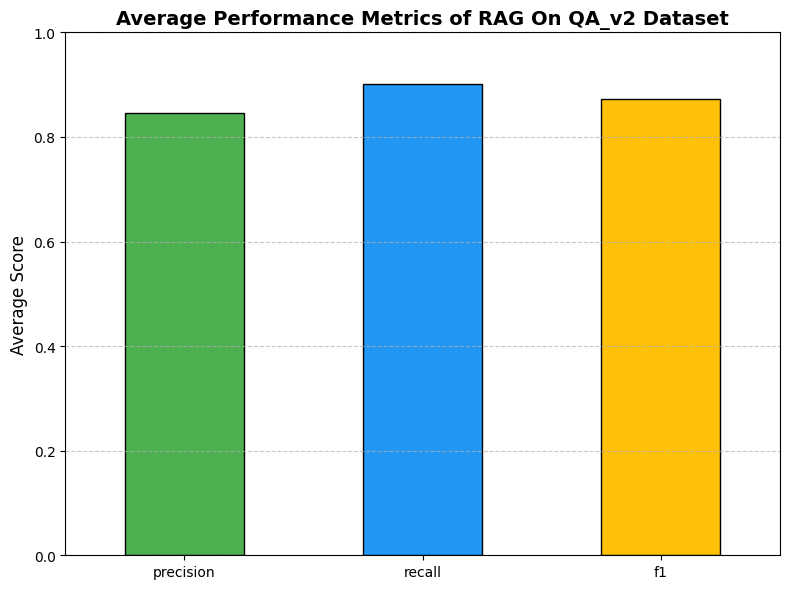

In [2]:
import matplotlib.pyplot as plt

# Calculate average scores
avg_scores = df_results[['precision', 'recall', 'f1']].mean()

# Create a bar plot
avg_scores.plot(kind='bar', figsize=(8, 6), color=['#4CAF50', '#2196F3', '#FFC107'], edgecolor='black')

plt.title("Average Performance Metrics of RAG On QA_v2 Dataset", fontsize=14, weight='bold')
plt.ylabel("Average Score", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.ylim(0, 1)  # Metrics are between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show
plt.savefig('average_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

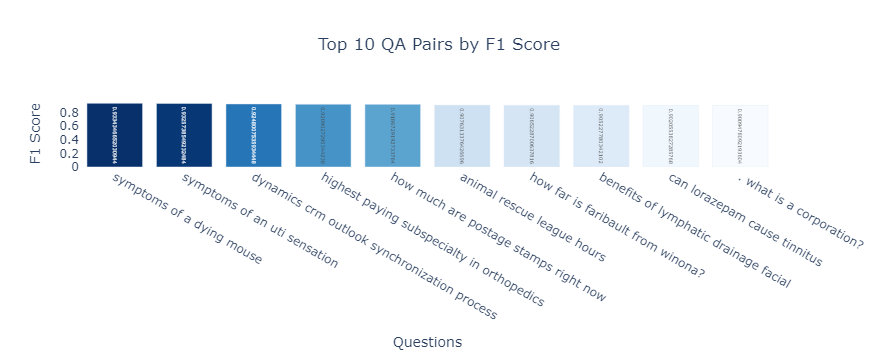

In [4]:
import plotly.express as px

# Example: Interactive bar chart for top 10 F1 scores
top_10 = df_results.nlargest(10, 'f1')

fig = px.bar(
    top_10,
    x='question',
    y='f1',
    title="Top 10 QA Pairs by F1 Score",
    labels={'f1': 'F1 Score', 'question': 'Questions'},
    text='f1',
    color='f1',
    color_continuous_scale='Blues'
)
fig.update_layout(
    xaxis_title="Questions",
    yaxis_title="F1 Score",
    title_x=0.5,
    font=dict(size=12),
    plot_bgcolor='white',
    coloraxis_showscale=False
)
fig.show()
fig.write_html("plot.html")